In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from tqdm import tqdm

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((32,32))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

#train, test = train_test_split(img_to_np("D:\\cybord\\img\\comp4_1\\*.jpg"),
#                               test_size = 0.2)

path = "D:\\cybord\\img\\comp1\\*.jpg"
train = img_to_np(path)
train = train.astype('float32') / 255.
#test = test.astype('float32') / 255.

print(train.shape)

(3187, 32, 32, 3)


In [3]:
encoding_dim = 1024

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(4*4*128),
      Reshape(target_shape=(4, 4, 128)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

# initialize outlier detector

od = OutlierAE( encoder_net=encoder_net,
                decoder_net=decoder_net,)
# train
od.fit(train, epochs=50, verbose=True,
       optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4))

od.infer_threshold(train, threshold_perc=97) 
od.threshold

50/50 [=] - 1s 18ms/step - loss: 5.7648e-04


0.0009865147364325824

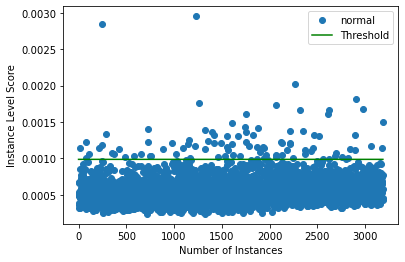

Counter({0: 3091, 1: 96})

In [4]:
preds = od.predict(train, outlier_type='instance',
            return_instance_score=True)

target = np.zeros(train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

Counter(preds['data']['is_outlier'])

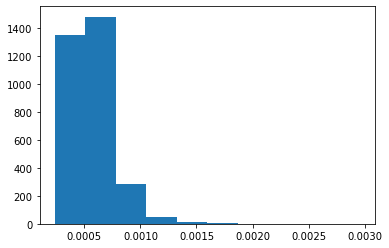

threshold: 0.0009865147364325824


In [5]:
plt.figure()
plt.hist(preds['data']['instance_score'])
plt.show()

thresh = od.threshold
print("threshold:", thresh)

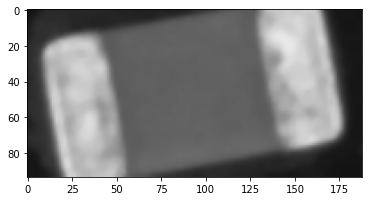

In [6]:
img_full = img_to_np(path, resize=False)

for i, pred in enumerate(preds['data']['is_outlier']):
    if(pred == 1):
        plt.imshow(img_full[i])
        plt.savefig("img/" + str(i) + ".jpg")